## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [1]:
import tensorflow as tf
import keras
from keras import layers

model = tf.keras.Sequential([
            tf.keras.Input(shape=(1, 8)),
            layers.Dense(16, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 16)             144       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             272       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


2023-04-29 18:41:14.953721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import  NN5_data
from model import OFL_Model
from utils import sigma_diff

K = 111
D = 433
P = 0.01        # Com. overhead reduction rate from FedOGD
L = 1           # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)
p2 = p * L
print(s, b, p, p2)

3 9 0.08615903990710687 0.08615903990710687


### 2. Experiment Setting

In [3]:
#NN5
train, test = NN5_data()
task = 'time'
window = 8
train = np.nan_to_num(train)
test = np.nan_to_num(test)

In [4]:
Model_list = []

Model_list.append(OFL_Model('FedOGD', task, K, [False, 0, 0], 1, 1, window))
Model_list.append(OFL_Model('OFedAvg', task, K, [False, 0, 0], P, 1, window))
#Model_list.append(OFL_Model('FedOMD', task, K, [False, 0, 0], 1, int(1/P), window))
Model_list.append(OFL_Model('OFedIQ', task, K, [True, s, b], p, 1, window))
#Model_list.append(OFL_Model('OFedIQ(L=8)', task, K, [True, s, b], p2, L, input_size))


2023-05-01 23:22:21.826201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Training

In [5]:
i_max = 120 #len(train[0]) - window - 1
iter_max = 1
print(iter_max, i_max)

1 120


In [6]:
for model in Model_list:
    for iter in range(iter_max):
        for i in range(i_max):
            model.train(train[:,i:i+window], train[:,i+window], ((i_max * iter) + (i+1)) % model.L)
        print(iter, end =',')
    print()

result_list = []
for model in Model_list:
    result_list.append(model.pull_result())

0,
0,
0,


### 3. Save Result

In [7]:
import pickle

#Code: data / data_90
code = input("Code: ")

for i, model in enumerate(Model_list):
    name = model.name
    with open(f"./result/{task}_{name}_{code}.pkl","wb") as f:
        pickle.dump(result_list[i], f)

In [8]:
len(result_list)

3

### 4. Plot Result

In [20]:
import pandas as pd
Data2 = pd.read_csv("dataset/NN5.csv")
train2 = Data2.iloc[:,112]
train2 = train2.values

train2[0]

128.2833779

/var/folders/5j/5y70dmpj6gz7vm0lv4mwhnzc0000gn/T/ipykernel_3703/773066522.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  r1[i] = r1[i] / div
/var/folders/5j/5y70dmpj6gz7vm0lv4mwhnzc0000gn/T/ipykernel_3703/773066522.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  r2[i] = r2[i] / div
/var/folders/5j/5y70dmpj6gz7vm0lv4mwhnzc0000gn/T/ipykernel_3703/773066522.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  r4[i] = r4[i] / div


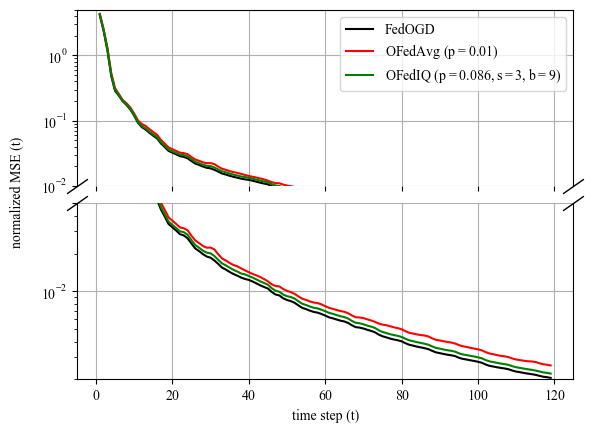

In [72]:
import pickle
import matplotlib.pyplot as plt

code = input('Code:')

with open(f"./result/{task}_FedOGD_{code}.pkl", "rb") as f:
    r1 = pickle.load(f)
with open(f"./result/{task}_OFedAvg_{code}.pkl", "rb") as f:
    r2 = pickle.load(f)
# with open(f"./result/{task}_FedOMD_{code}.pkl", "rb") as f:
#     r3 = pickle.load(f)
with open(f"./result/{task}_OFedIQ_{code}.pkl", "rb") as f:
    r4 = pickle.load(f)

for i in range(len(r1)):
    div = 0
    for j in range(i):
        div += train2[j]
    r1[i] = r1[i] / div
    r2[i] = r2[i] / div
    r4[i] = r4[i] / div

l1 = list(range(len(r1))) 
l2 = list(range(len(r2)))
# l3 = list(range(len(r3)))
l4 = list(range(len(r4)))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
d = 0.7
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15, linestyle="none", color='k', clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
fig.subplots_adjust(hspace=0.1)

ax1.set_yscale("log")
ax2.set_yscale("log")

ax1.set_ylim(0.01, 5)
ax2.set_ylim(0.002, 0.01)

ax1.set_yticks([0.01, 0.1, 1])
ax2.set_yticks([0.005, 0.01])

ax1.set_ylabel("")
ax2.set_ylabel("")

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.text(0.02, 0.50, "normalized MSE (t)", va='center', rotation = 'vertical', fontsize = 10)


ax1.plot(l1, r1, 'black', label=r'FedOGD')
ax1.plot(l2, r2, 'red', label=r'OFedAvg ($\mathdefault{p=0.01}$)')
#ax.plot(l3, r3, 'blue', label=r'FedOMD ($\mathdefault{L=10}$)')
ax1.plot(l4, r4, 'green', label=r'OFedIQ ($\mathdefault{p=0.086, s=3, b=9}$)')

ax2.plot(l1, r1, 'black')
ax2.plot(l2, r2, 'red')
#plt.plot(l3, r3, 'blue', label=r'FedOMD ($\mathdefault{L=10}$)')
ax2.plot(l4, r4, 'green')

ax2.set_xlabel('time step (t)')

# if task == 'clf':
#     plt.ylabel('Accuracy (t)')
# elif task == 'reg' or task == 'time':
#     plt.ylabel('normalized MSE (t)')
#     plt.yscale("log")

plt.rcParams["font.family"] = "Times New Roman"

ax1.grid()
ax2.grid()
ax1.legend()
#ax2.legend()

plt.savefig(f'./Figures/{task}_{code}.png', dpi=200, facecolor="white")
plt.show()


In [39]:
client_num = 
length = 39 #len(test)

test_result = []
test_result.append(test[client_num, window:length]) 
for model_num in range(len(Model_list)):
    tmp_array = []
    for i in range(length - window): 
        output = Model_list[model_num][client_num](test[client_num, i:i+window].reshape(1,window), training=False)
        tmp_array.append(output.numpy().item())
    test_result.append(tmp_array)

r1 = test_result[0]
r2 = test_result[1]
r3 = test_result[2]
r4 = test_result[3]

l1 = list(range(90, 90+len(r1)))
l2 = list(range(90, 90+len(r2)))
l3 = list(range(90, 90+len(r3)))
l4 = list(range(90, 90+len(r4)))

plt.plot(l1, r1, 'gray', label=r'True Value')
plt.plot(l2, r2, 'black', label=r'FedOGD')
plt.plot(l3, r3, 'red', label=r'OFedAvg ($\mathdefault{p=0.01}$)')
plt.plot(l4, r4, 'green', label=r'OFedIQ ($\mathdefault{p=0.086, s=3, b=9}$)')

plt.xlabel('time step (t)')

# if task == 'clf':
#     plt.ylabel('Accuracy (t)')
# elif task == 'reg' or task == 'time':
#     #plt.ylabel('MSE (t)')
#     #plt.yscale("log")

plt.title('Client 30')
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()

plt.savefig(f'./Figures/{task}_FIG1.png', dpi=200, facecolor="white")
plt.show()

SyntaxError: invalid syntax (2768365245.py, line 1)